
# Autoencoders



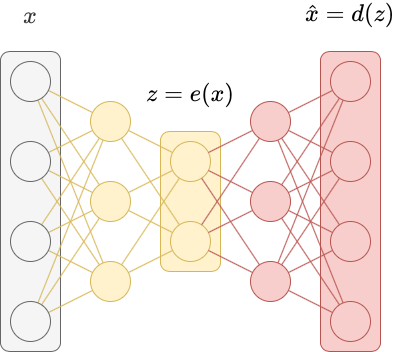

**Theory**

An Autoencoder is a type of generative model that learns to reconstruct its input data. It consists of two parts: an encoder and a decoder. The encoder takes the input data and maps it to a lower-dimensional representation called a latent space. The decoder then takes this latent space representation and reconstructs the original input data. 

During training, the Autoencoder learns to minimize the difference between the input data and the reconstructed data. By doing so, it learns to capture the underlying structure of the input data and can generate new data samples by sampling from the latent space and decoding them. 

Autoencoders can be used for a variety of tasks such as image generation, anomaly detection, and data compression. They are widely used in deep learning and have been shown to be effective in many applications.

In [1]:
from datasets.mnist_dataset import *
from common.utils import *

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

In [3]:
plt.gray()

<Figure size 432x288 with 0 Axes>

### Create dataset

In [4]:
mnist_dataset = MNISTDataset(size=1000)
mnist_loader = DataLoader(mnist_dataset, batch_size=1, shuffle=True)

### Create nn model

In [5]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 300),
            torch.nn.ReLU(),
            torch.nn.Linear(300, 2),
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 300),
            torch.nn.ReLU(),
            torch.nn.Linear(300, 28 * 28),
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def decoder_only(self, x):
        return self.decoder(x)

In [6]:
model = AE()
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

### Train Autoencoder

In [7]:
EPOCHS = 20

In [11]:
loss = train_model_base(model, mnist_loader, loss_function, optimizer, EPOCHS)

Epoch 1/20. time: 2.740s
train loss: 3881.491904


Epoch 2/20. time: 3.017s
train loss: 3621.212394


Epoch 3/20. time: 3.203s
train loss: 3564.320714


Epoch 4/20. time: 3.388s
train loss: 3491.582220


Epoch 5/20. time: 3.202s
train loss: 3424.978093


Epoch 6/20. time: 2.845s
train loss: 3395.118687


Epoch 7/20. time: 3.173s
train loss: 3349.058540


Epoch 8/20. time: 3.672s
train loss: 3336.811936


Epoch 9/20. time: 2.694s
train loss: 3288.601260


Epoch 10/20. time: 2.694s
train loss: 3297.630063


Epoch 11/20. time: 2.614s
train loss: 3253.791161


Epoch 12/20. time: 2.661s
train loss: 3236.178837


Epoch 13/20. time: 3.135s
train loss: 3221.578018


Epoch 14/20. time: 3.311s
train loss: 3199.741828


Epoch 15/20. time: 4.033s
train loss: 3183.899358


Epoch 16/20. time: 4.808s
train loss: 3173.435933


Epoch 17/20. time: 3.035s
train loss: 3173.207221


Epoch 18/20. time: 3.433s
train loss: 3144.999078


Epoch 19/20. time: 2.686s
train loss: 3138.934389


Epoch 20/20. time: 2.

### Results

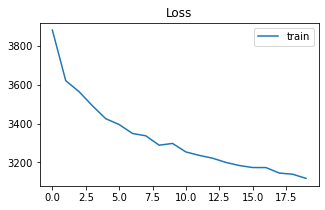

In [12]:
plot_train(loss)

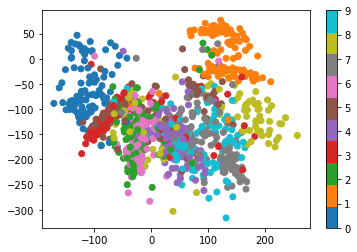

In [13]:
plot_latent(mnist_loader, model)

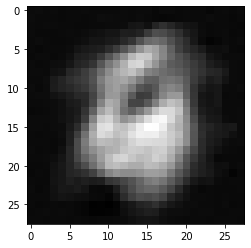

In [14]:
generated = model.decoder(torch.tensor([0., -100.])).detach().numpy().reshape(28,28)
plt.imshow(generated)

# Variational AutoEncoder

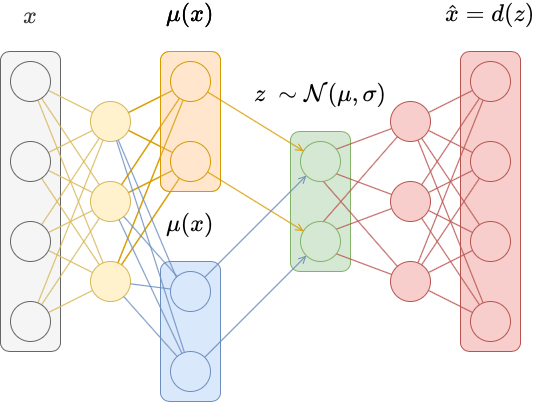

$$
\mathbb{KL}\left( \mathcal{N}(\mu, \sigma) \parallel \mathcal{N}(0, 1) \right) = \sum_{x \in X} \left( \sigma^2 + \mu^2 - \log \sigma - \frac{1}{2} \right)
$$

**Theory**

A Variational Autoencoder (VAE) is a type of generative model that learns to reconstruct its input data while simultaneously learning a probabilistic distribution over the latent space. 

Similar to a traditional Autoencoder, a VAE consists of an encoder and a decoder. The encoder takes the input data and maps it to a lower-dimensional representation called a latent space. However, instead of mapping to a single point in the latent space, the encoder outputs a mean and variance for each dimension of the latent space. 

During training, the VAE learns to minimize the difference between the input data and the reconstructed data, as well as minimizing the difference between the learned distribution over the latent space and a predefined prior distribution (usually a Gaussian distribution). By doing so, the VAE learns to capture the underlying structure of the input data and can generate new data samples by sampling from the learned distribution over the latent space and decoding them.

VAEs can be used for a variety of tasks such as image generation, data compression, and anomaly detection. They are widely used in deep learning and have been shown to be effective in many applications.

In [15]:
class VariationalEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 300)
        self.linear2 = nn.Linear(300, 2)
        self.linear3 = nn.Linear(300, 2)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc
        self.N.scale = self.N.scale
        self.kl = 0
    
    def forward(self, x):
        x = self.linear1(x)
        mu =  self.linear2(x)
        sigma = self.linear3(x)
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - sigma - 1/2).sum()
        return z

In [16]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 300),
            torch.nn.ReLU(),
            torch.nn.Linear(300, 28 * 28),
        )
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [17]:
model = VariationalAutoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

### Train VAE

In [18]:
EPOCHS = 40

In [19]:
vae_loss = train_model_vae(model, mnist_loader, optimizer, EPOCHS)

Epoch 1/40. time: 3.361s
train loss: 3617314.955625


Epoch 2/40. time: 3.172s
train loss: 3166785.129062


Epoch 3/40. time: 2.836s
train loss: 3113952.041469


Epoch 4/40. time: 3.054s
train loss: 3089403.149625


Epoch 5/40. time: 3.009s
train loss: 3081012.611719


Epoch 6/40. time: 3.470s
train loss: 3030599.933000


Epoch 7/40. time: 2.790s
train loss: 3070248.913875


Epoch 8/40. time: 2.851s
train loss: 3014855.663125


Epoch 9/40. time: 2.763s
train loss: 3059014.989250


Epoch 10/40. time: 2.615s
train loss: 2976053.331625


Epoch 11/40. time: 2.587s
train loss: 3608403.391188


Epoch 12/40. time: 2.536s
train loss: 3087801.351125


Epoch 13/40. time: 2.626s
train loss: 2943449.316344


Epoch 14/40. time: 2.849s
train loss: 2947064.116500


Epoch 15/40. time: 2.845s
train loss: 2940761.675656


Epoch 16/40. time: 2.641s
train loss: 2944277.991500


Epoch 17/40. time: 2.738s
train loss: 5485280.804500


Epoch 18/40. time: 2.967s
train loss: 3491883.980750


Epoch 19/40. time: 

### Results

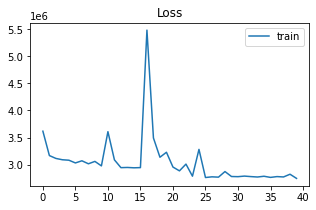

In [20]:
plot_train(vae_loss)

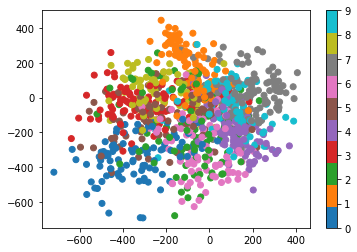

In [21]:
plot_latent(mnist_loader, model)

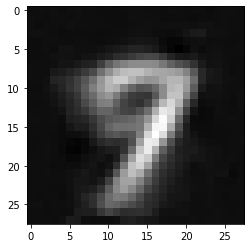

In [22]:
generated = model.decoder(torch.tensor([200.,-0.])).detach().numpy().reshape(28,28)
plt.imshow(generated)